In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext
from tensorflow.keras.models  import model_from_json
from tensorflow.keras.preprocessing import image
import requests

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Model Loaded successfully...")
        print("Detecting License Plate ... ")
        return model
    except Exception as e:
        print(e)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, wpod_net, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor


def recognize_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
    cv2.imwrite('detection/placas.jpg', dilation)

    try:
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    im2 = dilation.copy()
    
    plate_num = 0
    for cnt in sorted_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        height, width = im2.shape
        if height / float(h) > 6: continue
        ratio = h / float(w)
        if ratio < 1.1: continue
        area = h * w
        if width / float(w) > 15: continue
        if area < 100: continue
        rect = cv2.rectangle(im2, (x,y), (x+w, y+h), (0,255,0),2)
        roi = thresh[y-5:y+h+5, x-5:x+w+5]
        roi = cv2.bitwise_not(roi)
        roi = cv2.medianBlur(roi, 5)
        cv2.imwrite(f"letras/{plate_num}.jpg", roi)
        plate_num += 1
    print(plate_num)
    return plate_num


<Response [200]>
Model Loaded successfully...
Detecting License Plate ... 
1/1 [==============================] - 2s 2s/step


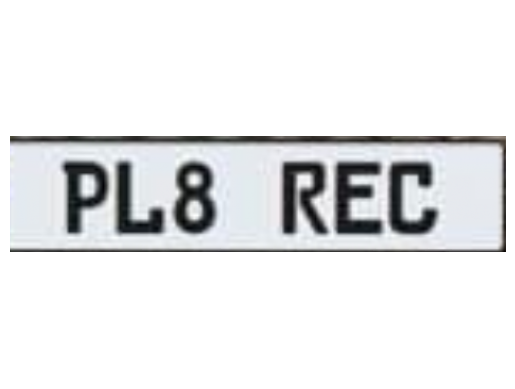

In [2]:

url = "https://platerecognizer.com/wp-content/uploads/2020/07/Blur-license-plates.jpg"
response = requests.get(url)
print(response)
with open("dataset\placa.jpg", "wb") as f:
    f.write(response.content)
    f.close()

wpod_net = load_model("models/wpod-net.json")
test_image_path = "dataset\placa.jpg"
vehicle, LpImg, cor = get_plate(test_image_path, wpod_net)

fig = plt.figure()
plt.axis(False)
ax=fig.add_subplot()
plt.axis('off')
plt.imshow(LpImg[0])
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('detection/placas.jpg', bbox_inches=extent)

In [3]:
!pip install pydot
!pip install graphviz

In [7]:
from keras.utils import plot_model
# ver el modelo gráficamente
plot_model(wpod_net)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
placa = cv2.imread('detection\placas.jpg')
letters=recognize_plate(placa)

In [ ]:
with open('models\model_emnist.json', 'r') as json_file:
    model_json = json_file.read()
    json_file.close()
model_emnist = model_from_json(model_json)
model_emnist.load_weights('models\weights_emnist.h5')
print('Modelo EMNIST cargado')

In [ ]:
#from tensorflow.keras.preprocessing import image
img = image.load_img('letras\\5.jpg', target_size=(28,28), color_mode='grayscale')
X = image.img_to_array(img)
X = np.expand_dims(X, axis=0)
preds = model_emnist.predict(X)
print(np.argmax(preds))